In [2]:
import scanpy as sc
import scvi
import seaborn as sns
from scvi.model import SCVI
import torch
import anndata as ad
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
import matplotlib.colors as mcolors

/home/baldinelli/miniforge3/envs/celltype_annotation_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sc.settings.set_figure_params(dpi=200, facecolor="white")

In [3]:
# torch.cuda.is_available()
# torch.cuda.get_device_name(0)

## Label transfer with scvi-tools

In [4]:
# Load reference (labeled) and query (unlabeled) datasets
ref = sc.read_h5ad("../data/annotated_datasets/adata_adfca_body_v1.0.h5ad")
query = sc.read_h5ad("../data/2ndRun/fly_sci_leiden.h5ad")

In [5]:
ref

AnnData object with n_obs × n_vars = 264422 × 16219
    obs: 'sample', 'dataset', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'sex', 'tissue', 'age', 'genotype', 'sex_age', 'genoAge', 'genoSex', 'genoAgeSex', 'adfca_annotation', 'adfca_annotation_broad', 'adfca_annotation_group', 'adfca_annotation_subcluster'
    var: 'gene_ids', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'adfca_annotation_colors', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'latent_gene_encoding'
    layers: 'logNormalize_exp', 'umi_counts'
    obsp: 'connectivities', 'distances'

In [6]:
ref.obs['adfca_annotation_broad']

GGGACAATCGCGGACT-1_10_D20CEMB                      gut cell
GGGTGTCTCGTGGACC-1_10_D20CEMB      male reproductive system
CTCATCGGTCCACACG-1_10_D20CEMB                      oenocyte
ACCAACAGTAGACGTG-1_10_D20CEMB                      gut cell
TCGCTCACATCGCCTT-1_10_D20CEMB                         gland
                                            ...            
GAGTTGTCACATTCGA-1_8_D10ABFB                     CNS neuron
GAAGCGACAGTTACCA-1_8_D10ABFB           female germline cell
AGCGTCGTCCATGATG-1_8_D10ABFB                    unannotated
CACAGGCGTCTGTGTA-1_8_D10ABFB     female reproductive system
AGCGTCGGTGGCCTCA-1_8_D10ABFB     female reproductive system
Name: adfca_annotation_broad, Length: 264422, dtype: category
Categories (19, object): ['CNS neuron', 'PNS neuron', 'cardial cell', 'epithelial cell', ..., 'oenocyte', 'sensory neuron', 'tracheal cell', 'unannotated']

In [7]:
ref.obs['adfca_annotation_broad']

GGGACAATCGCGGACT-1_10_D20CEMB                      gut cell
GGGTGTCTCGTGGACC-1_10_D20CEMB      male reproductive system
CTCATCGGTCCACACG-1_10_D20CEMB                      oenocyte
ACCAACAGTAGACGTG-1_10_D20CEMB                      gut cell
TCGCTCACATCGCCTT-1_10_D20CEMB                         gland
                                            ...            
GAGTTGTCACATTCGA-1_8_D10ABFB                     CNS neuron
GAAGCGACAGTTACCA-1_8_D10ABFB           female germline cell
AGCGTCGTCCATGATG-1_8_D10ABFB                    unannotated
CACAGGCGTCTGTGTA-1_8_D10ABFB     female reproductive system
AGCGTCGGTGGCCTCA-1_8_D10ABFB     female reproductive system
Name: adfca_annotation_broad, Length: 264422, dtype: category
Categories (19, object): ['CNS neuron', 'PNS neuron', 'cardial cell', 'epithelial cell', ..., 'oenocyte', 'sensory neuron', 'tracheal cell', 'unannotated']

In [8]:
unique_labels = ref.obs['adfca_annotation_broad'].unique()
print("Unique annotation names:")
unique_labels

Unique annotation names:


['gut cell', 'male reproductive system', 'oenocyte', 'gland', 'fat cell', ..., 'cardial cell', 'PNS neuron', 'glial cell', 'sensory neuron', 'female germline cell']
Length: 19
Categories (19, object): ['CNS neuron', 'PNS neuron', 'cardial cell', 'epithelial cell', ..., 'oenocyte', 'sensory neuron', 'tracheal cell', 'unannotated']

In [9]:
n_unique = ref.obs['tissue'].nunique()
print(f"Number of unique annotations: {n_unique}")

Number of unique annotations: 1


In [10]:
query.var['V3']

gene_symbol
CG17636             Gene Expression
RhoGAP1A            Gene Expression
tyn                 Gene Expression
lncRNA:CR45473      Gene Expression
CG17707             Gene Expression
                         ...       
pre-rRNA:CR45846    Gene Expression
pre-rRNA:CR45847    Gene Expression
mt:tRNA:Gly-TCC     Gene Expression
mt:lrRNA            Gene Expression
mt:srRNA            Gene Expression
Name: V3, Length: 14306, dtype: category
Categories (1, object): ['Gene Expression']

In [11]:
query

AnnData object with n_obs × n_vars = 29514 × 14306
    obs: 'cell', 'n.umi', 'Size_Factor', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'doublet_score', 'predicted_doublet', 'n_counts', 'n_genes_clipped', 'leiden', 'temp', 'leiden_res0_2', 'leiden_res0_3', 'leiden_res0_4', 'leiden_res0_5', 'leiden_res1'
    var: 'V2', 'V3', 'clean_id', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'X_name', 'cds_version', 'hvg', 'leiden', 'leiden_colors', 'leiden_res0_2', 'leiden_res0_2_colors', 'leiden_res0_3', 'leiden_res0_3_colors', 'leiden_res0_4', 'leiden_res0_4_colors', 'leiden

## 1. Harmonize gene spaces
Why?
scANVI (and all scVI‐tools models) requires that all cells share the same feature (gene) space. Ref has 16 219 genes, the query only 14 315.

In [12]:
dups = query.var_names[query.var_names.duplicated()]
print(f"Number of duplicated genes: {len(dups)}")
print(dups)

Number of duplicated genes: 0
Index([], dtype='object', name='gene_symbol')


In [13]:
common_genes = ref.var_names.intersection(query.var_names)

# subset both AnnData objects
ref = ref[:, common_genes].copy()
query = query[:, common_genes].copy()

In [14]:
common_genes

Index(['128up', '14-3-3epsilon', '14-3-3zeta', '140up', '18SrRNA-Psi:CR41602',
       '18w', '26-29-p', '28SrRNA-Psi:CR40596', '28SrRNA-Psi:CR40741',
       '28SrRNA-Psi:CR41609',
       ...
       'zf30C', 'zfh1', 'zfh2', 'zip', 'zld', 'zormin', 'zpg', 'zuc', 'zyd',
       'zye'],
      dtype='object', length=13842)

## 2. Create a combined AnnData
Why?
scANVI is a semi-supervised model that jointly embeds labeled and unlabeled cells. We concatenate them into one adata and keep track of which batch they come from

In [15]:
#mark origin
ref.obs['batch'] = 'ref'
query.obs['batch'] = 'query'

# create a labels column: use ref labels, and mark query as "Unknown"
label_key = 'adfca_annotation_broad'
ref.obs[label_key] = ref.obs['adfca_annotation_broad']
query.obs[label_key] = 'Unknown'

# concatenate
adata_combined = ad.concat(
    [ref, query],
    join='inner',           #keep only genes present in both
    label='batch',          # name of the new obs column
    keys=['ref', 'query'],  # values that go into adata.obs['batch']
    index_unique=None       
)

In [16]:
adata_combined

AnnData object with n_obs × n_vars = 293936 × 13842
    obs: 'n_genes_by_counts', 'total_counts', 'leiden', 'adfca_annotation_broad', 'batch'
    obsm: 'X_pca', 'X_umap'

## 3. Preprocess (optional but recommended)
Why?
Standard preprocessing ensures data quality and identifies the most informative genes. Using batch_key='dataset_type' ensures we find genes that are variable across both datasets, accounting for potential batch effects.

In [17]:
# Store raw counts
adata_combined.raw = adata_combined

sc.pp.normalize_total(adata_combined, target_sum=1e4)
sc.pp.log1p(adata_combined)

sc.pp.highly_variable_genes(adata_combined, n_top_genes=2000, batch_key='batch')
adata_combined.var['highly_variable'] = adata_combined.var['highly_variable_nbatches'] >= 1

## 4. Setup anndata for scVI
Why?
This tells scVI‐tools where to find batch labels and which column contains your partial cell‐type labels.

In [18]:
scvi.model.SCANVI.setup_anndata(
    adata_combined,
    layer=None,  # to use the normlized data in X
    labels_key='adfca_annotation_broad', 
    unlabeled_category='Unknown',   #what to call unlabeled cells
    batch_key='batch'        # in order to account for dataset differences
)

## 5. Train a base scVI model
Why?
scANVI builds on a pretrained scVI latent embedding to model batch effects and gene‐expression variation.
- n_latent=30: Creates a 30-dimensional latent representation
- n_hidden=128, n_layers=2: Neural network architecture parameters
- max_epochs=400: Maximum training iterations
- early_stopping=True: Prevents overfitting by stopping when validation loss stops improving

In [19]:
# Initialize the model & Train the model with model_training_scanvi.py

# Load the trained model
model = scvi.model.SCANVI.load("../data/2ndRun/broad_trained_model", adata=adata_combined)

INFO     File ../data/2ndRun/broad_trained_model/model.pt already downloaded                                       


## 6. Predict cell-type labels
Why?
Now you can assign each cell in your concatenated adata a label from the reference vocabulary. The latent representation captures the essential features learned by the model. Predictions give you the most likely cell type for each cell, while soft predictions provide confidence scores for all possible cell types.

In [20]:
# Get the latent representation
adata_combined.obsm['X_scANVI'] = model.get_latent_representation()

# Predict cell types for all cells (including query)
predictions = model.predict(soft=False)
prediction_scores = model.predict(soft=True)  # Get confidence scores

# Add predictions to the data
adata_combined.obs['scANVI_prediction'] = predictions
adata_combined.obsm['scANVI_prediction_scores'] = prediction_scores

## 7. Extract Query Results
This extracts the annotations for your query cells and adds them back to your original query dataset for downstream analysis.

In [21]:
adata_combined.obs

,n_genes_by_counts,total_counts,leiden,adfca_annotation_broad,batch,_scvi_batch,_scvi_labels,scANVI_prediction
GGGACAATCGCGGACT-1_10_D20CEMB,225,3318.0,15,gut cell,ref,0,11,gut cell
GGGTGTCTCGTGGACC-1_10_D20CEMB,1535,5877.0,45,male reproductive system,ref,0,14,male reproductive system
CTCATCGGTCCACACG-1_10_D20CEMB,1407,5823.0,2,oenocyte,ref,0,16,oenocyte
ACCAACAGTAGACGTG-1_10_D20CEMB,1763,5868.0,17,gut cell,ref,0,11,gut cell
TCGCTCACATCGCCTT-1_10_D20CEMB,1599,5876.0,19,gland,ref,0,9,gland
...,...,...,...,...,...,...,...,...
ATGGCGCCTG_GGTCCAGGAG_CTCTGAGCTG_TTCTCTGAGA,267,472.0,8,Unknown,query,1,19,female reproductive system
ATTGGCAGAT_AGGTCAATTA_CTGACGTTTG_TTCTCTGAGA,795,2025.0,1,Unknown,query,1,19,fat cell
ATAAGGACTC_CCAAGCTGAA_CTGACGTTTG_TTCTCTGAGA,469,1249.0,7,Unknown,query,1,19,female reproductive system
ATAAGGACTC_GTTGACGGCC_CTGACGTTTG_TTCTCTGAGA,630,910.0,16,Unknown,query,1,19,female germline cell


In [22]:
# Extract only the query cells with their predictions
query_mask = adata_combined.obs['batch']=='query'
query_annotated = adata_combined[query_mask].copy()

# add predictions to your original query object
query.obs['scANVI_prediction'] = query_annotated.obs['scANVI_prediction'].values
query.obsm['X_scANVI'] = query_annotated.obsm['X_scANVI']
query.obsm['scANVI_prediction_scores'] = query_annotated.obsm['scANVI_prediction_scores']

## 8.  Quality Assessment
Quality assessment helps us understand how well the annotation worked. High confidence scores and good separation in UMAP space indicate successful annotation.

In [23]:
# Compute UMAP on scANVI latent space
# sc.pp.neighbors(adata_combined, use_rep='X_scANVI', n_neighbors=15)
# sc.tl.umap(adata_combined)

In [24]:
# adata_combined.write("../data/2ndRun/adata_combined_broad.h5ad")

In [25]:
adata_combined = sc.read_h5ad("../data/2ndRun/adata_combined_broad.h5ad")

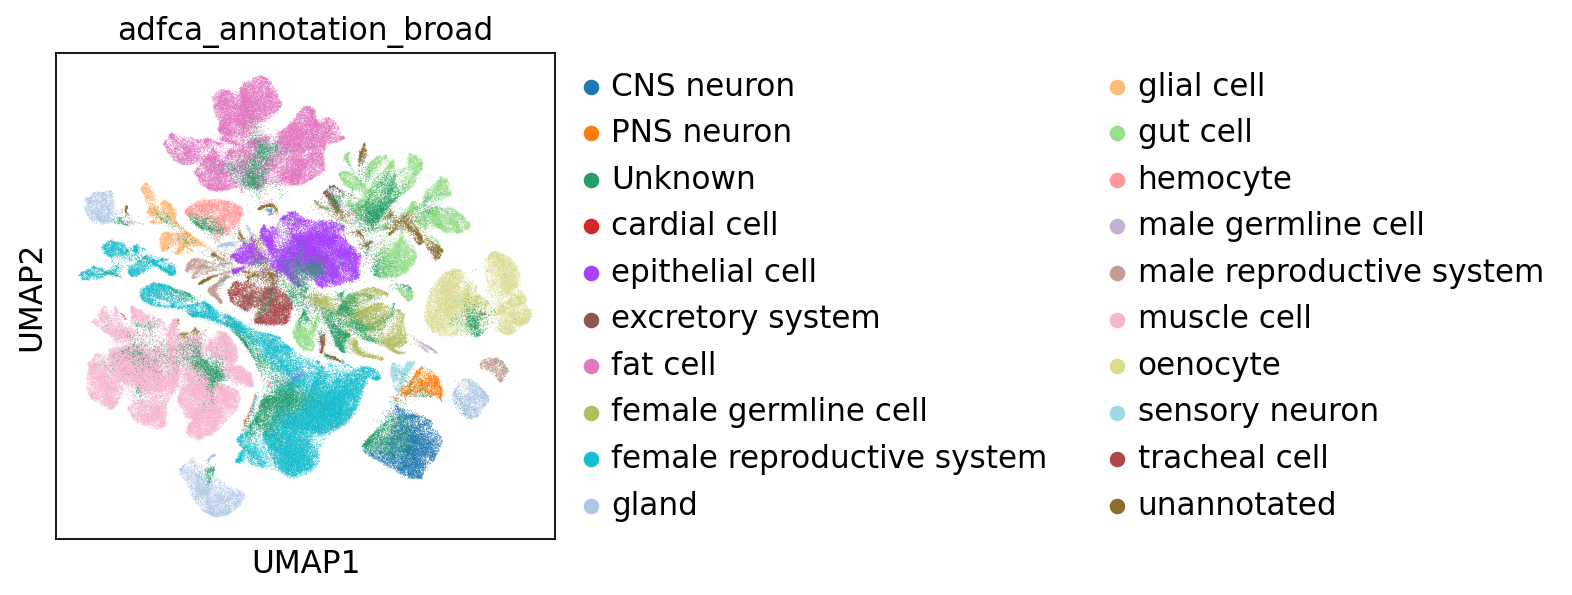

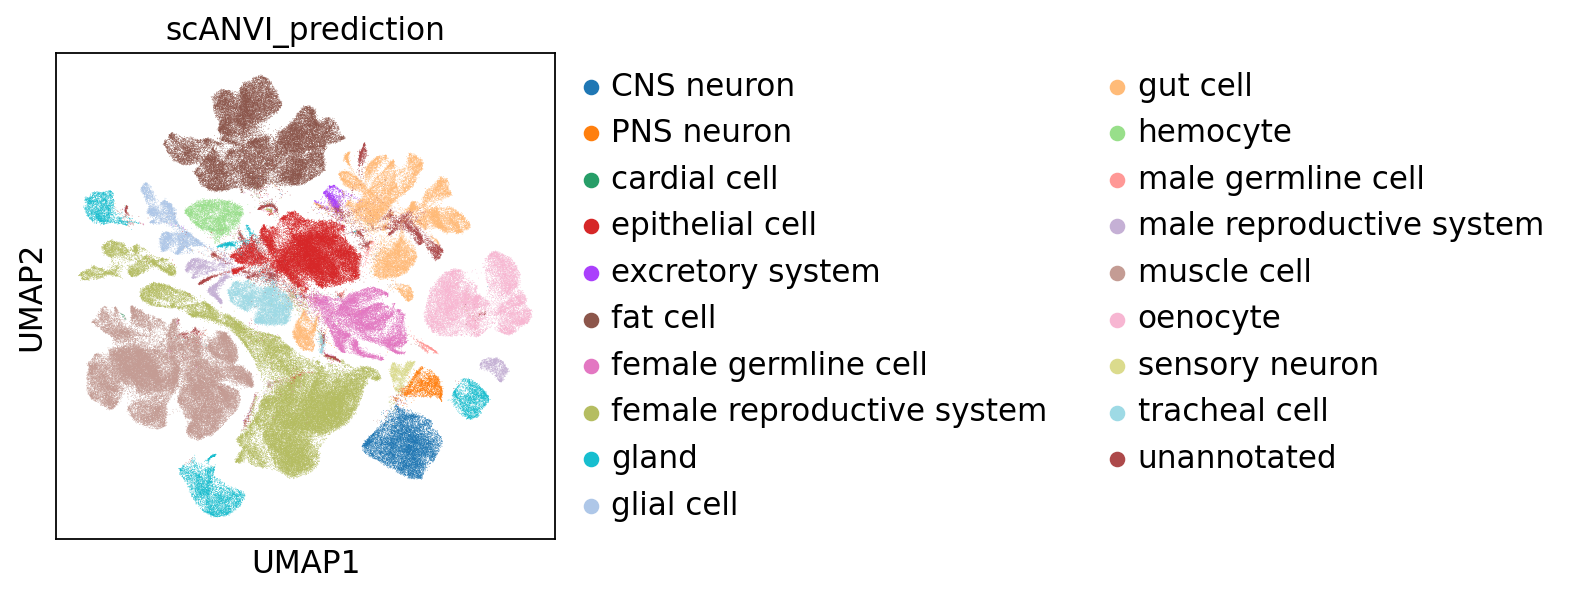

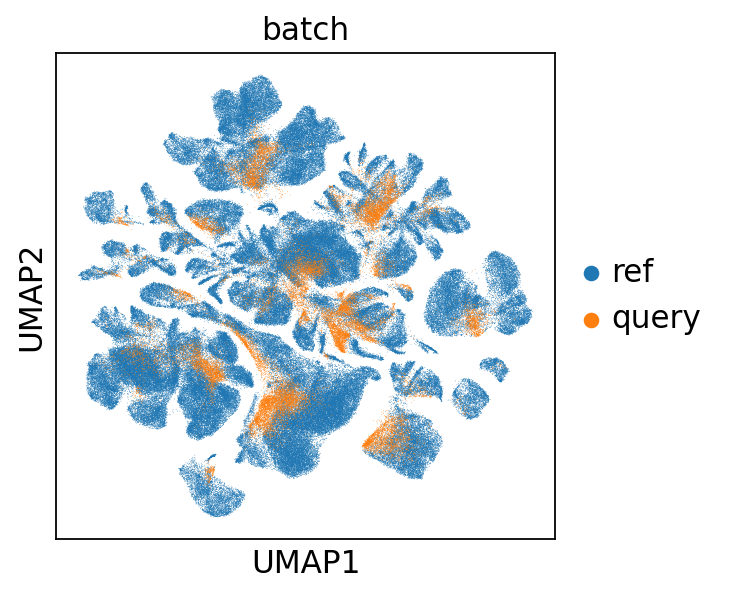

In [28]:
sc.settings.set_figure_params(dpi_save=300, facecolor='white')

sc.pl.umap(adata_combined, color='adfca_annotation_broad', 
           legend_loc='right margin', 
           legend_fontsize='medium',
           save='_annotations_broad.pdf')  # Saves high-quality PDF

sc.pl.umap(adata_combined, color='scANVI_prediction', 
           legend_loc='right margin', 
           legend_fontsize='medium',
           save='_predictions_broad.pdf')  # Saves high-quality PDF

sc.pl.umap(adata_combined, color='batch', 
           legend_loc='right margin', 
           legend_fontsize='medium',
           save='_batch_broad.pdf')  # Saves high-quality PDF

In [27]:
# check prediction confidence
max_scores = np.max(query.obsm['scANVI_prediction_scores'], axis=1)
print(f"Mean prediction confidence: {np.mean(max_scores):.3f}")
print(f"Median prediction confidence: {np.median(max_scores):.3f}")

Mean prediction confidence: 0.983
Median prediction confidence: 1.000


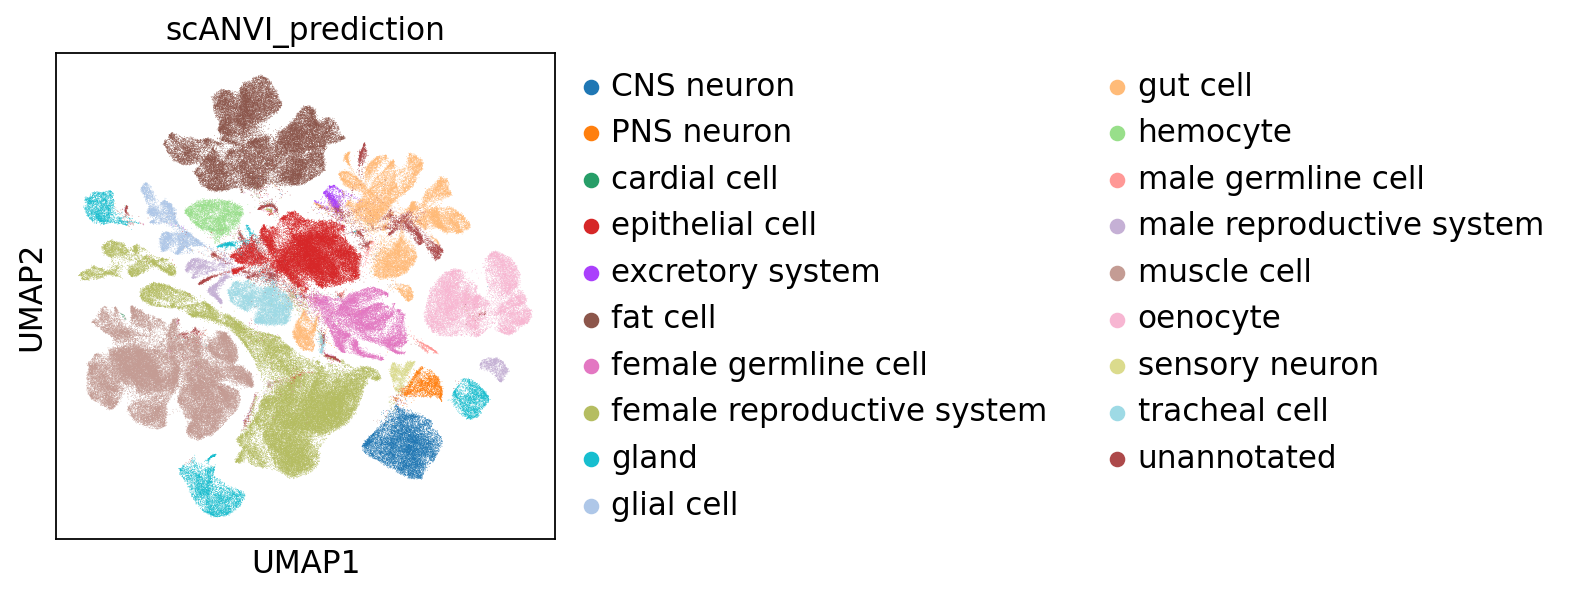

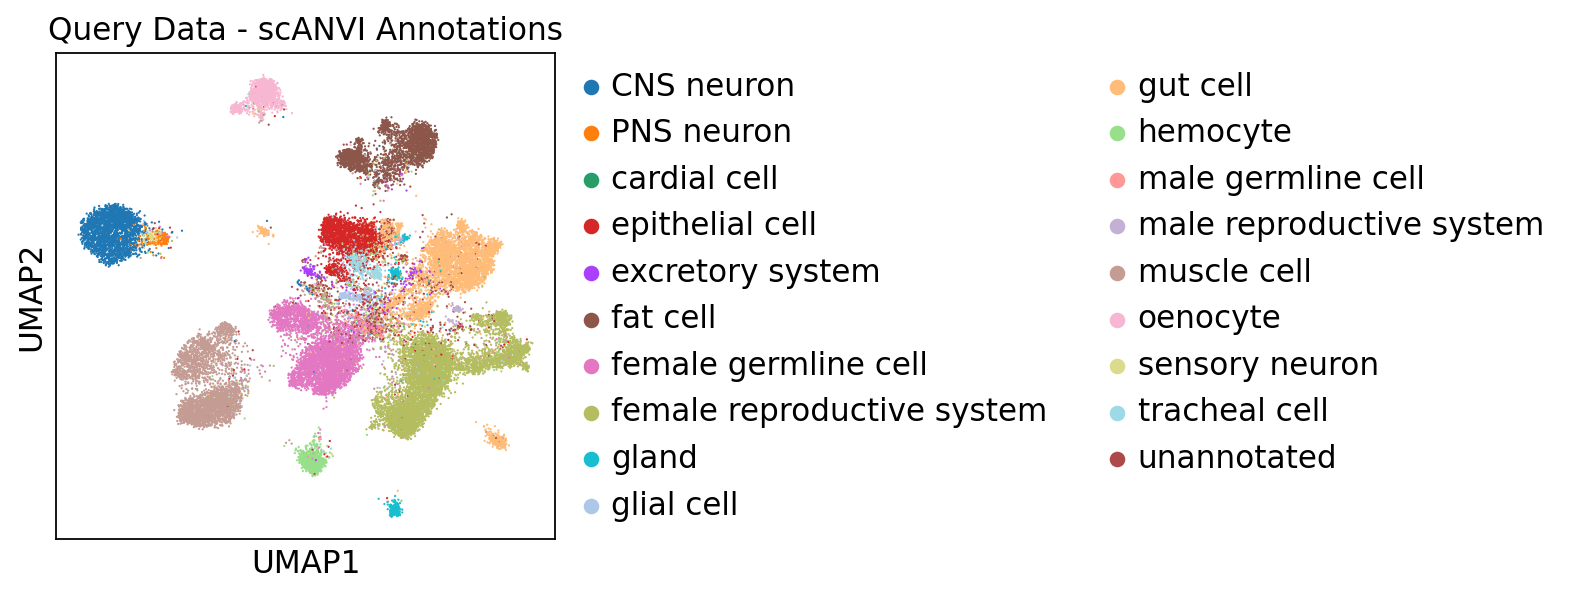

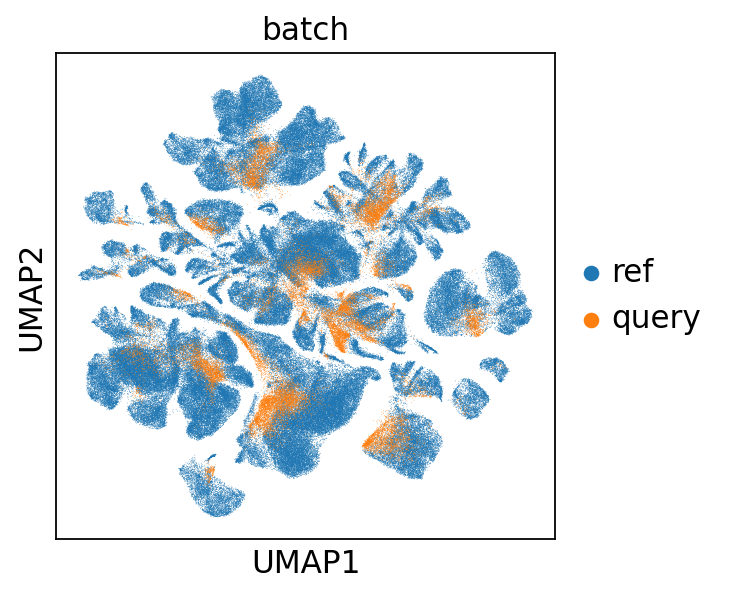

In [ ]:
plt.rcParams['savefig.transparent'] = True
sc.settings.figdir = "../figures"

# Get the unique categories and a color map from the full (reference) dataset
categories = adata_combined.obs['scANVI_prediction'].cat.categories
# Get the colors already assigned by Scanpy, or define your own
colors = adata_combined.uns['scANVI_prediction_colors']

query.obs['scANVI_prediction'] = pd.Categorical(
    query.obs['scANVI_prediction'],
    categories=categories  # ensures consistent mapping
)

# Plot reference
sc.pl.umap(adata_combined, 
           color='scANVI_prediction', 
           palette=colors,
           legend_loc='right margin', 
           legend_fontsize='medium',
           save='_predictions_broad.pdf')

# Plot query using same colors
sc.pl.umap(query, 
           color='scANVI_prediction', 
           palette=colors,
           legend_loc='right margin', 
           legend_fontsize='medium',
           title='Query Data - scANVI Annotations',
           save='_query_annotation_broad.pdf')


sc.pl.umap(adata_combined, color='batch', 
           legend_loc='right margin', 
           legend_fontsize='medium',
           save='_batch_broad.pdf')

## Step 9: Filter Low-Confidence Predictions (Optional)
Some predictions may be uncertain. Filtering based on confidence helps ensure you only use reliable annotations for downstream analysis.

In [30]:
# confidence_threshold = 0.7
# high_confidence_mask = max_scores > confidence_threshold

# print(f"Cells with high confidence predictions: {np.sum(high_confidence_mask)}/{len(max_scores)}")

# #mark low-confidence predictions
# query.obs['scANVI_prediction_filtered'] = query.obs['scANVI_prediction'].copy()
# query.obs.loc[~high_confidence_mask, 'scANVI_prediction_filtered'] = 'Low_confidence'

## Check freq of different cell types in transferred annotation

In [31]:
print(adata_combined.obs.columns)

Index(['n_genes_by_counts', 'total_counts', 'leiden', 'adfca_annotation_broad',
       'batch', '_scvi_batch', '_scvi_labels', 'scANVI_prediction'],
      dtype='object')


In [32]:
cell_type_labels = adata_combined.obs['scANVI_prediction'].cat.categories

In [33]:
df_scores = pd.DataFrame(
    prediction_scores,
    index=adata_combined.obs_names,
    columns=cell_type_labels
)


In [34]:
adata_combined.obs['scANVI_prediction']

GGGACAATCGCGGACT-1_10_D20CEMB                                    gut cell
GGGTGTCTCGTGGACC-1_10_D20CEMB                    male reproductive system
CTCATCGGTCCACACG-1_10_D20CEMB                                    oenocyte
ACCAACAGTAGACGTG-1_10_D20CEMB                                    gut cell
TCGCTCACATCGCCTT-1_10_D20CEMB                                       gland
                                                          ...            
ATGGCGCCTG_GGTCCAGGAG_CTCTGAGCTG_TTCTCTGAGA    female reproductive system
ATTGGCAGAT_AGGTCAATTA_CTGACGTTTG_TTCTCTGAGA                      fat cell
ATAAGGACTC_CCAAGCTGAA_CTGACGTTTG_TTCTCTGAGA    female reproductive system
ATAAGGACTC_GTTGACGGCC_CTGACGTTTG_TTCTCTGAGA          female germline cell
CGCGGCCATA_GTTGACGGCC_CTGACGTTTG_TTCTCTGAGA    female reproductive system
Name: scANVI_prediction, Length: 293936, dtype: category
Categories (19, object): ['CNS neuron', 'PNS neuron', 'cardial cell', 'epithelial cell', ..., 'oenocyte', 'sensory neuron', 'trac

In [35]:
# Step 1: Sum confidence scores for each cell type (i.e. column-wise sum)
cell_type_totals = df_scores.sum(axis=0)

# Step 2: Normalize so that all values sum to 1
cell_type_probs = cell_type_totals / cell_type_totals.sum()

In [36]:
cell_type_probs

CNS neuron                    0.040549
PNS neuron                    0.008955
cardial cell                  0.000050
epithelial cell               0.102624
excretory system              0.004059
fat cell                      0.132270
female germline cell          0.048445
female reproductive system    0.188557
gland                         0.036008
glial cell                    0.018076
gut cell                      0.084309
hemocyte                      0.017908
male germline cell            0.002343
male reproductive system      0.013934
muscle cell                   0.183310
oenocyte                      0.056628
sensory neuron                0.004992
tracheal cell                 0.028494
unannotated                   0.028491
dtype: float32

## Barplot showing the percentages of each cell type

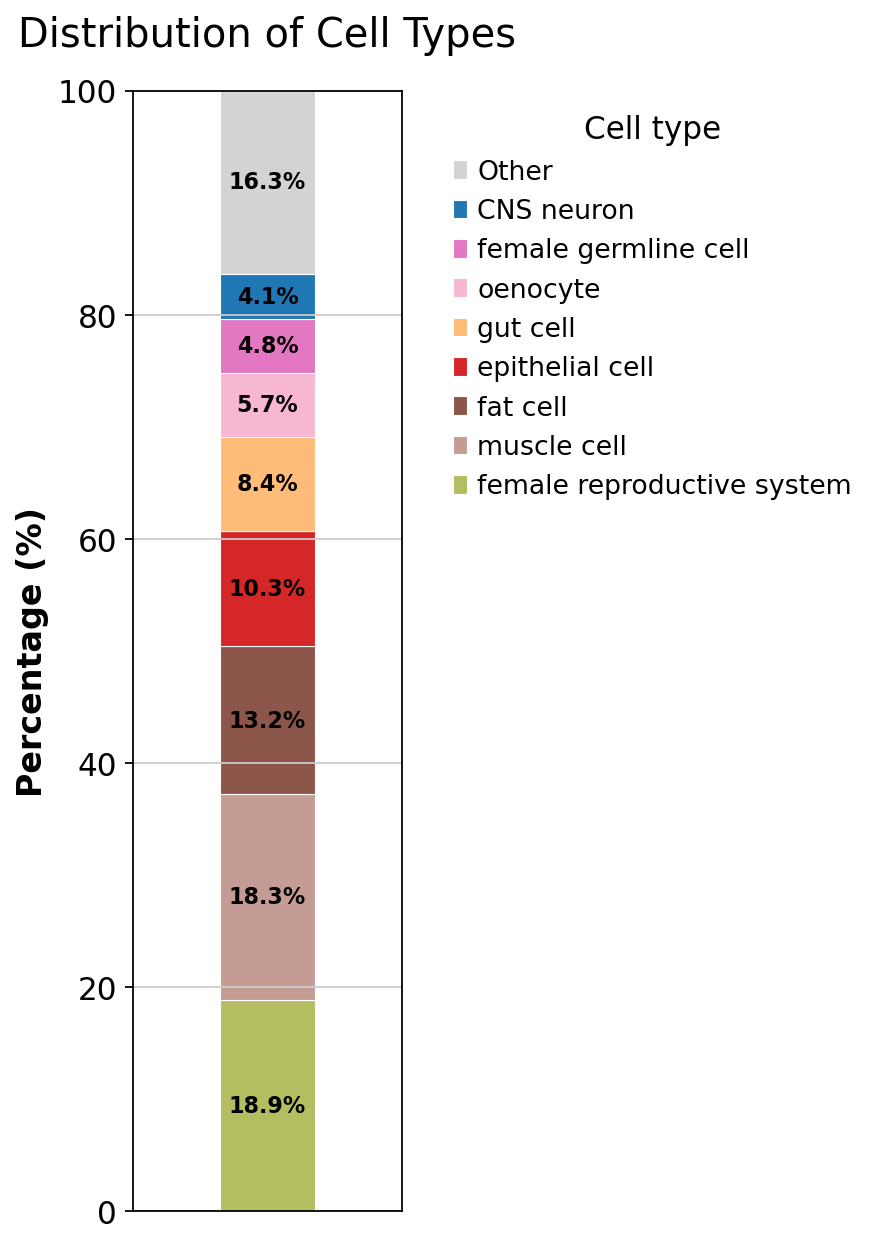

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

plt.rcParams['savefig.transparent'] = True

# Sort by frequency (descending)
cell_type_probs_sorted = cell_type_probs.sort_values(ascending=False)

# Group small fractions into "Other"
threshold = 0.04  # 5%
large = cell_type_probs_sorted[cell_type_probs_sorted >= threshold]
small = cell_type_probs_sorted[cell_type_probs_sorted < threshold]

# Assign 'Other' and reorder so it's last
if len(small) > 0:
    other_sum = small.sum()
    large = pd.concat([large, pd.Series({'Other': other_sum})])

# Final sorted order: descending, but "Other" last
cell_type_probs_grouped = large.drop('Other', errors='ignore').sort_values(ascending=False)
if 'Other' in large:
    cell_type_probs_grouped['Other'] = other_sum  # append at the end

# Get scANVI colors from AnnData
categories = adata_combined.obs['scANVI_prediction'].cat.categories
scANVI_colors = dict(zip(categories, adata_combined.uns['scANVI_prediction_colors']))

# Assign consistent colors, use light gray for "Other"
colors = []
for label in cell_type_probs_grouped.index:
    if label in scANVI_colors:
        colors.append(scANVI_colors[label])
    else:
        colors.append('#d3d3d3')  # Light gray

# Plot
plt.figure(figsize=(6, 8))
bottom = 0
bar_width = 0.35

for i, (cell_type, freq) in enumerate(cell_type_probs_grouped.items()):
    perc = freq * 100
    plt.bar(0, perc, width=bar_width, bottom=bottom, 
            color=colors[i], edgecolor='white', linewidth=0.5,
            label=cell_type)
    
    if perc > 2:
        plt.text(0, bottom + perc / 2, f'{perc:.1f}%', 
                 ha='center', va='center', fontweight='bold', 
                 fontsize=10, color='black')

    bottom += perc

plt.xlim(-0.5, 0.5)
plt.ylim(0, 100)
plt.ylabel('Percentage (%)', fontsize=15, fontweight='bold')
plt.title('Distribution of Cell Types', 
          fontsize=18, pad=20)
plt.xticks([])

# Legend with "Other" last
handles, labels = plt.gca().get_legend_handles_labels()

# Reorder legend so "Other" is last
if 'Other' in labels:
    other_index = labels.index('Other')
    handles.append(handles.pop(other_index))
    labels.append(labels.pop(other_index))

# Reverse the order to match bar stack (bottom to top)
handles = handles[::-1]
labels = labels[::-1]

legend = plt.legend(handles, labels, bbox_to_anchor=(1.1, 1), loc='upper left',
                    fontsize=12, title='Cell type', frameon=False)

plt.tight_layout()
plt.savefig("../figures/celltype_distribution_bar.pdf", bbox_inches='tight')
plt.savefig("../figures/celltype_distribution_bar.svg", format='svg', dpi=300,
            bbox_inches='tight', transparent=True)
plt.show()

In [4]:
gut_df

Cell_Type
crop                                               0.216361
enterocyte of posterior adult midgut epithelium    0.143040
enteroblast                                        0.098448
cardia (1)                                         0.095630
intestinal stem cell                               0.093704
enterocyte of anterior adult midgut epithelium     0.082923
adult hindgut                                      0.067723
adult midgut-hindgut hybrid zone                   0.047217
enterocyte-like                                    0.041195
enteroendocrine cell                               0.026722
copper cell                                        0.024128
principal cell*                                    0.019855
midgut large flat cell                             0.016157
cardia (2)                                         0.014634
adult midgut enterocyte                            0.009115
adult differentiating enterocyte                   0.003147
Name: Frequency, dtype: float6

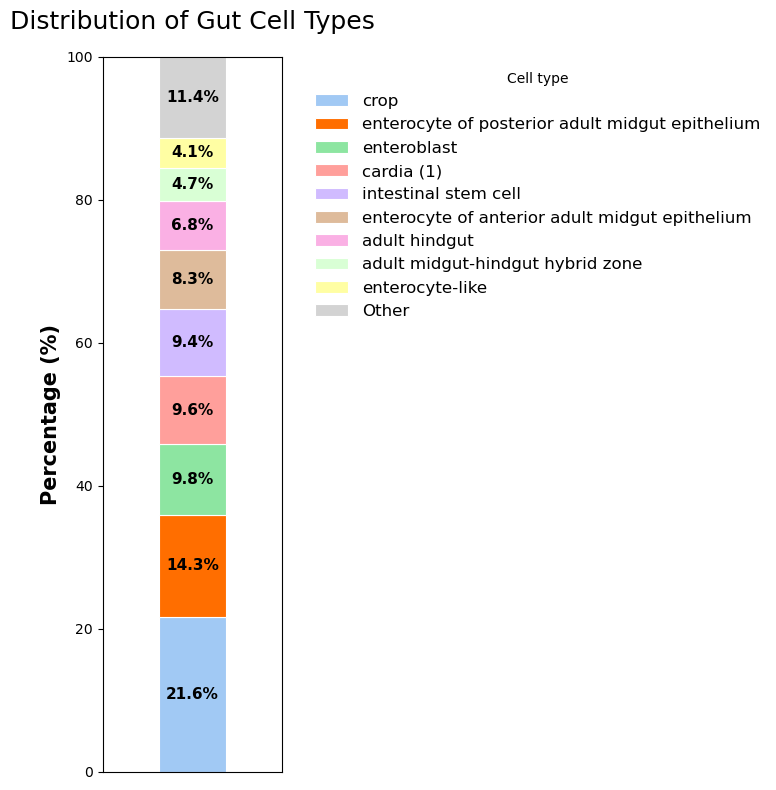

In [ ]:
plt.rcParams['savefig.transparent'] = True
sc.settings.figdir = "../figures"

# Load data
gut_df = pd.read_csv("../data/2ndRun/gut_cell_frequencies.csv")
gut_df = gut_df.set_index("Cell_Type")["Frequency"]
gut_df = gut_df.sort_values(ascending=False)

# Group small fractions into "Other"
threshold = 0.04
large = gut_df[gut_df >= threshold]
small = gut_df[gut_df < threshold]

if len(small) > 0:
    other_sum = small.sum()
    large = pd.concat([large, pd.Series({'Other': other_sum})])

# Reorder: sort all but keep 'Other' last
cell_type_freqs_grouped = large.drop('Other', errors='ignore').sort_values(ascending=False)
if 'Other' in large:
    cell_type_freqs_grouped['Other'] = other_sum

# Generate pastel colors
n_colors = len(cell_type_freqs_grouped)
pastel_palette = sns.color_palette("pastel", n_colors)

# Assign colors
custom_colors = []
for i, label in enumerate(cell_type_freqs_grouped.index):
    if label == "Other":
        custom_colors.append("#d3d3d3")  # Light gray
    elif label == "enterocyte of posterior adult midgut epithelium":
        custom_colors.append("#ff6e00")
    elif label == "adult midgut-hindgut hybrid zone":
        custom_colors.append("#d9ffd5")
    else:
        custom_colors.append(pastel_palette[i])

# Plot using Rectangle patches for a thick vertical bar
plt.figure(figsize=(8, 8))  # Wider to allow fat bar
bottom = 0
bar_width = 3
bar_left = -bar_width / 2

for i, (cell_type, freq) in enumerate(cell_type_freqs_grouped.items()):
    perc = freq * 100
    rect = plt.Rectangle((bar_left, bottom), bar_width, perc, 
                         facecolor=custom_colors[i], label=cell_type,
                         edgecolor='white', linewidth=0.8)
    plt.gca().add_patch(rect)

    if perc > 2:
        plt.text(0, bottom + perc / 2, f'{perc:.1f}%',
                 ha='center', va='center', fontweight='bold',
                 fontsize=11, color='black')
    bottom += perc

plt.xlim(-bar_width - 1, bar_width + 1)  # make space for full bar
plt.ylim(0, 100)
plt.ylabel('Percentage (%)', fontsize=15, fontweight='bold')
plt.title('Distribution of Gut Cell Types',
          fontsize=18, pad=20)
plt.xticks([])

# Legend with "Other" last
handles, labels = plt.gca().get_legend_handles_labels()
if 'Other' in labels:
    idx = labels.index('Other')
    handles.append(handles.pop(idx))
    labels.append(labels.pop(idx))

legend = plt.legend(handles, labels, bbox_to_anchor=(1.1, 1), loc='upper left',
                    fontsize=12, title='Cell type', frameon=False)

plt.tight_layout()
plt.savefig("../figures/gut_celltype_distribution_vertical_bar.pdf", bbox_inches='tight')
plt.savefig("../figures/gut_celltype_distribution_vertical_bar.svg", format='svg', dpi=300,
            bbox_inches='tight', transparent=True)
plt.show()